# Emulação de um som de gaita utilizando Python

### Neste _notebook_ está o processo de emulação de um som de gaita diatônica em Dó proposto pelo autor do trabalho utilizando a linguagem de programação _Python_
Na primeira célula é realizada a importação das bibliotecas e funções necessárias para a realização da emulação

In [1]:
from scipy.io.wavfile import write, read
from scipy import signal
from scipy.fftpack import fft, ifft, fftshift, fftfreq
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd

Leitura do sinal da gaita

In [3]:
# Leitura do sinal da gaita
fs, gaita_in = read('../../gaita.wav')
print(gaita_in.dtype)   # imprimindo o tipo do arquivo da gaita para fazer a normalização logo abaixo

# Normalizando amplitude para valores entre -1 e 1 e definindo o tipo float 32bits
gaita_in = np.float32(gaita_in)/(2**15 - 1)

# Array de tempo
amostras = np.arange(len(gaita_in))
t = amostras / fs

int16


Execução do som pela função play do _sounddevice_

In [4]:
# Play áudio de entrada
sd.play(gaita_in)

Obtendo a envoltória com filtro passa-baixa utilizando um filtro _Butterworth_ de terceira ordem e frequência de corte de 30 Hz

In [5]:
# Obtendo a envoltória com filtro passa-baixa
gaita_abs = abs(gaita_in)

fc = 30                #freq de corte
Wn = fc / (fs / 2)     #freq de corte normalizada

# Utilizando filtro butterworth de terceira ordem para aplicar um passa-baixa no sinal
b, a = signal.butter(3, Wn)
env_filt = signal.filtfilt(b, a, gaita_abs)

# Suprimir ruído desconsiderando amplitudes pequenas
for i in range (env_filt.size):
    if env_filt[i] < 0.005: env_filt[i] = 0

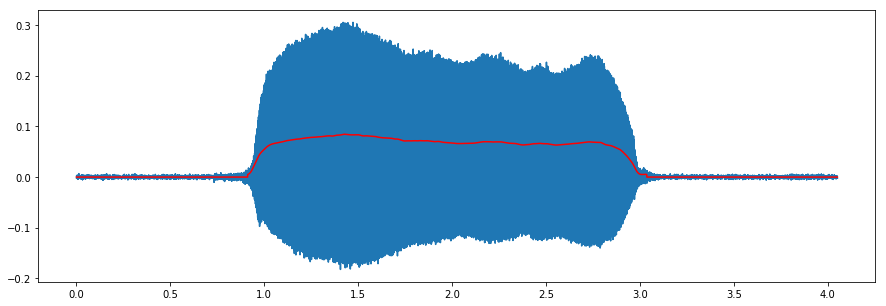

In [6]:
# Plot envoltória com filtro

plt.figure(figsize=(15,5))
plt.plot(t, gaita_in)
plt.plot(t, env_filt, 'r')

plt.show()

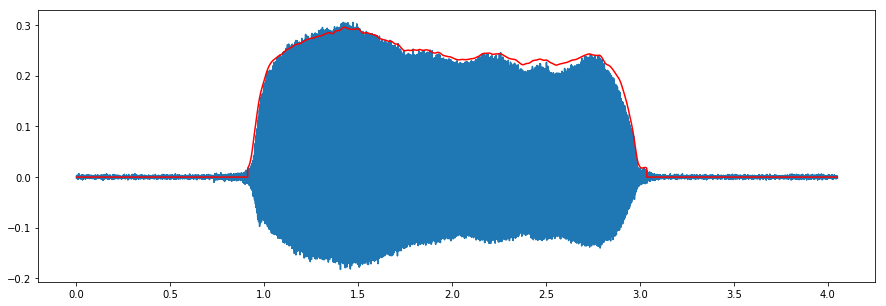

In [7]:
# Multiplicando a envoltória encontrada por uma constante para se aproximar da envoltória do sinal original

plt.figure(figsize=(15,5))

ganho_filt = 3.5

env_filt_ganho = ganho_filt * env_filt
plt.plot(t, gaita_in)
plt.plot(t, env_filt_ganho, 'r')

plt.show()

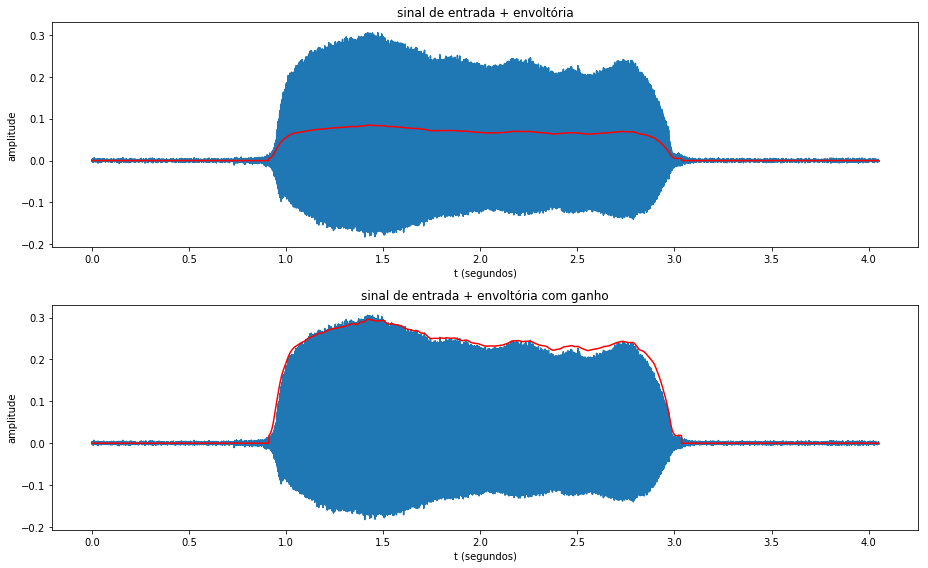

In [8]:
# Plot das duas envoltórias, sem ganho e com ganho

# %matplotlib tk

plt.figure(figsize=(13,8))

plt.subplot(2,1,1)
plt.plot(t, gaita_in)
plt.plot(t, env_filt, 'r')
plt.ylabel('amplitude')
plt.xlabel('t (segundos)')
plt.title('sinal de entrada + envoltória')

plt.subplot(2,1,2)
plt.plot(t, gaita_in)
plt.plot(t, env_filt_ganho, 'r')
plt.ylabel('amplitude')
plt.xlabel('t (segundos)')
plt.title('sinal de entrada + envoltória com ganho')

plt.tight_layout()
plt.ion()

plt.show()

Análise do sinal pela transformada discreta de Fourier

In [9]:
# Aplicando FFT no sinal da gaita

gaita_fft = fft(gaita_in)

# Definindo eixo das frequencias
# Está variando de 0 a fs/2 e pegando só metade do comprimento da fft, ou seja, só a porção positiva

gaita_freqs = np.linspace(0.0, fs/2, gaita_fft.size//2)

# Acertando a amplitude da fft
# Os valores absolutos da FFT dividido pela metade da frequencia de amostragem

amp_gaita_fft = abs(gaita_fft[:int(gaita_fft.size/2)]) / (fs/2)

# Obtendo o angulo da FFT
fase_gaita_fft = np.angle(gaita_fft[:int(gaita_fft.size/2)])

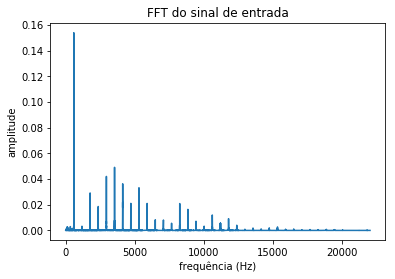

In [10]:
#Plot FFT domínio da frequência

plt.plot(gaita_freqs, amp_gaita_fft)

plt.ylabel('amplitude')
plt.xlabel('frequência (Hz)')
plt.title('FFT do sinal de entrada')

plt.show()

Algoritmo para encontrar a localização dos picos mais relevantes da transformada discreta de Fourier

In [11]:
# Encontrando as frequências e amplitude relativa
pico_loc = []
gaita_fft_copy = amp_gaita_fft.copy()

# Laço para identificar a localização dos picos das ffts, desconsiderando os valores próximos

lim_amp = 0.015   # Limiar para amplitude de 0.015
while True:
    pico = np.amax(gaita_fft_copy)
    if pico < lim_amp: break
    loc, = np.where(gaita_fft_copy == pico)
    pico_loc.append(int(loc))
    gaita_fft_copy[int(loc-10):int(loc+10)] = 0

Nesta etapa serão realizadas a soma dos senos mais significativos para formação do timbre emulado.

Aproveita-se para também gerar as outras notas multiplicando a frequência pelas razões apresentadas no TCC.

In [12]:
# Somando os senos mais significativos para formar os timbres das notas
# Para formar as outras notas da escala, utilizou-se a relação entre notas de acordo com a afinação natural

timbre_fase_C = 0
timbre_fase_D = 0       # a nota D (Ré) é a mesma nota do sinal original
timbre_fase_E = 0
timbre_fase_F = 0
timbre_fase_G = 0
timbre_fase_A = 0
timbre_fase_B = 0

for loc in pico_loc:
    timbre_fase_C += (amp_gaita_fft[loc] * np.cos(2 * np.pi * (8/9*gaita_freqs[loc]) * t + fase_gaita_fft[loc]))
    timbre_fase_D += (amp_gaita_fft[loc] * np.cos(2 * np.pi * gaita_freqs[loc] * t + fase_gaita_fft[loc]))
    timbre_fase_E += (amp_gaita_fft[loc] * np.cos(2 * np.pi * (10/9*gaita_freqs[loc]) * t + fase_gaita_fft[loc]))
    timbre_fase_F += (amp_gaita_fft[loc] * np.cos(2 * np.pi * (32/27*gaita_freqs[loc]) * t + fase_gaita_fft[loc]))
    timbre_fase_G += (amp_gaita_fft[loc] * np.cos(2 * np.pi * (4/3*gaita_freqs[loc]) * t + fase_gaita_fft[loc]))
    timbre_fase_A += (amp_gaita_fft[loc] * np.cos(2 * np.pi * (40/27*gaita_freqs[loc]) * t + fase_gaita_fft[loc]))
    timbre_fase_B += (amp_gaita_fft[loc] * np.cos(2 * np.pi * (5/3*gaita_freqs[loc]) * t + fase_gaita_fft[loc]))

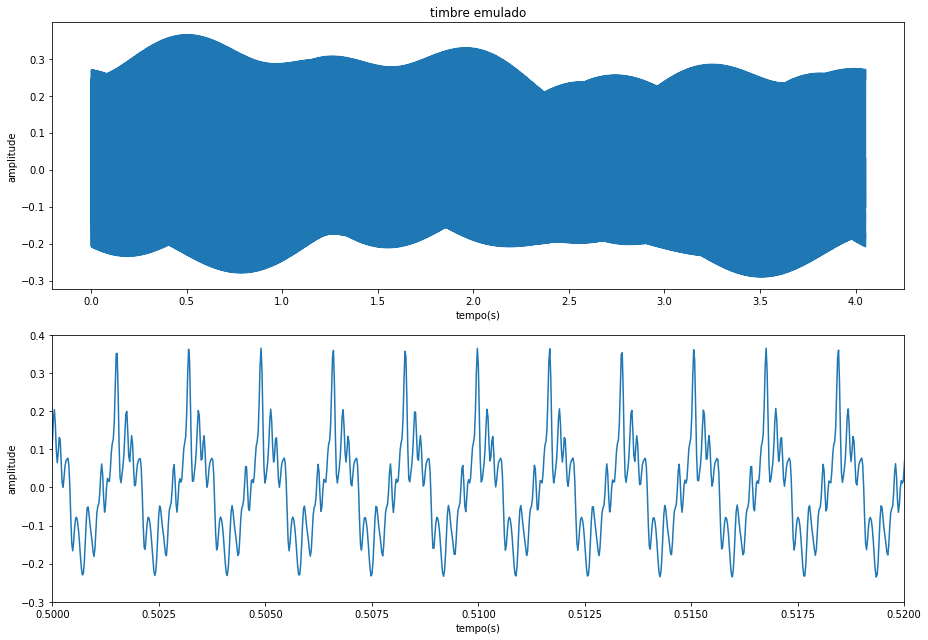

In [13]:
# Plot do timbre emulado da gaita original (nota Ré)

plt.figure(figsize=(13,9))

plt.subplot(2,1,1)
plt.plot(t, timbre_fase_D)
plt.ylabel('amplitude')
plt.xlabel('tempo(s)')
plt.title('timbre emulado')

plt.subplot(2,1,2)
plt.plot(t, timbre_fase_D)
plt.ylabel('amplitude')
plt.xlabel('tempo(s)')
# plt.title('timbre emulado')
plt.axis([0.5, 0.52, -0.3, 0.4])

plt.tight_layout()
plt.ion()

plt.show()

Execução do timbre emulado do som da gaita

In [14]:
sd.play(timbre_fase_D)

In [15]:
# Execução do timbre de gaita de nota A (Lá) gerado pela relacao de parentesco
sd.play(timbre_fase_A)

Obtenção dos sinais emulados após multiplicação pela envoltória. Multiplicação por um ganho para aumentar a amplitude de saída

In [16]:
# Devido a multiplicacao de duas amplitudes menores que um, é necessário realizar um ganho para melhorar a saída do sinal
ganho_emu = 3.5

gaita_emu_A = ganho_emu * timbre_fase_A * env_filt_ganho
gaita_emu_B = ganho_emu * timbre_fase_B * env_filt_ganho
gaita_emu_C = ganho_emu * timbre_fase_C * env_filt_ganho
gaita_emu_D = ganho_emu * timbre_fase_D * env_filt_ganho
gaita_emu_E = ganho_emu * timbre_fase_E * env_filt_ganho
gaita_emu_F = ganho_emu * timbre_fase_F * env_filt_ganho
gaita_emu_G = ganho_emu * timbre_fase_G * env_filt_ganho

In [17]:
# Execução do som de saída emulado da gaita original

sd.play(gaita_emu_D)

In [18]:
# Execução do som de saída emulado da nota F (Fá) gerado pela relação de parentesco

sd.play(gaita_emu_F)

Salvando os arquivos emulados de gaita

In [19]:
# Converter novamente para int16

out_A = gaita_emu_A.copy()
out_B = gaita_emu_B.copy()
out_C = gaita_emu_C.copy()
out_D = gaita_emu_D.copy()
out_E = gaita_emu_E.copy()
out_F = gaita_emu_F.copy()
out_G = gaita_emu_G.copy()

# Invertendo a normalizacao feita no começo
out_A *= (2**15 - 1)
out_B *= (2**15 - 1)
out_C *= (2**15 - 1)
out_D *= (2**15 - 1)
out_E *= (2**15 - 1)
out_F *= (2**15 - 1)
out_G *= (2**15 - 1)

# Convertendo em int16 novamente
out_A = np.int16(out_A)
out_B = np.int16(out_B)
out_C = np.int16(out_C)
out_D = np.int16(out_D)
out_E = np.int16(out_E)
out_F = np.int16(out_F)
out_G = np.int16(out_G)

write('../../resultados/gaita_emu_A.wav', fs, out_A)
write('../../resultados/gaita_emu_B.wav', fs, out_B)
write('../../resultados/gaita_emu_C.wav', fs, out_C)
write('../../resultados/gaita_emu_D.wav', fs, out_D)
write('../../resultados/gaita_emu_E.wav', fs, out_E)
write('../../resultados/gaita_emu_F.wav', fs, out_F)
write('../../resultados/gaita_emu_G.wav', fs, out_G)